In [1]:
import sys
import os

def get_FGCE_Directory():
    """Get the path of the 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness' directory."""
    current_dir = os.getcwd()
    while os.path.basename(current_dir) != 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness':
        current_dir = os.path.dirname(current_dir)
        if current_dir == os.path.dirname(current_dir):
            return None
    return current_dir
FGCE_DIR = get_FGCE_Directory()

sys.path.append(FGCE_DIR)
def get_path_separator():
    """Get the system-specific directory separator."""
    return os.sep

sep = get_path_separator()
sys.path.append(FGCE_DIR + f'{sep}src')
sys.path.append(FGCE_DIR + f'{sep}baselines')

# Comparison with GLOBE-CE approach 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from baselines.dataset import dataset_loader
from FGCE import *
from kernel import *
from sklearn import preprocessing
import time
from tqdm import tqdm
import pickle as pk
import warnings
import os
import json
from globe_ce import GLOBE_CE
import math
from utils import GraphBuilder
warnings.filterwarnings("ignore")

In [3]:
name = 'compas'
group_identifier = "sex"
classifier = "lr"
dataset = dataset_loader(name, dropped_features=[], n_bins=None)

X = dataset.data.iloc[:, :-1]
y = dataset.data.iloc[:, -1] 
print(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=482, shuffle=True)

print(f"Number of samples in x_test: {len(x_test)}")
print(f"Number of samples in y_test: {len(y_test)}")

if classifier == "lr":
    clf = LogisticRegression(random_state=482)
    clf.fit(x_train, list(y_train))
    print(f"Training accuracy: {clf.score(x_train, list(y_train))}")
    print(f"Testing accuracy: {clf.score(x_test, list(y_test))}")

elif classifier == "xgb":
    clf = XGBClassifier(random_state=482)
    clf.fit(x_train, y_train)
    print("Training accuracy:", clf.score(x_train, y_train))
    print("Testing accuracy:", clf.score(x_test, y_test))
    
elif classifier == "dnn":
    clf = tf.keras.models.Sequential([
				tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
				tf.keras.layers.Dropout(0.5),
				tf.keras.layers.Dense(32, activation='relu'),
				tf.keras.layers.Dropout(0.5),
				tf.keras.layers.Dense(1, activation='sigmoid')  
			])

    clf.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    
    clf.fit(x_train, y_train, epochs=10, batch_size=16, validation_split=0.1)  
    print("Training accuracy:", clf.evaluate(x_train, y_train)[1])
    print("Testing accuracy:", clf.evaluate(x_test, y_test)[1])

      age  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0      69              0               0                0             0   
1      34              0               0                0             0   
2      24              0               0                1             4   
3      44              0               0                0             0   
4      41              0               0                0            14   
...   ...            ...             ...              ...           ...   
6162   23              0               0                0             0   
6163   23              0               0                0             0   
6164   57              0               0                0             0   
6165   33              0               0                0             3   
6166   23              0               0                0             2   

      c_charge_degree  sex = Female  sex = Male  race = African-American  \
0                   0  

In [4]:
def get_FN_Negatives_Positives(x_test, y_test, clf, tp):
    """
    This function will return the False Negatives and all the negatively classified data points

    Parameters:
    -----------
    x_test: pandas DataFrame
        Test features
    y_test: pandas Series
        Test target variable
    clf: classifier
        Trained classifier model
    tp: float
        Threshold probability for classifying as positive

    Returns:
    --------
    positives_df: pandas DataFrame
        DataFrame containing positively classified data points
    negatives_df: pandas DataFrame
        DataFrame containing negatively classified data points that are false negatives
    """

    positives = []  
    negatives = []  

   
    data = pd.concat([x_test, y_test], axis=1)

  
    FEATURE_COLUMNS = x_test.columns
    TARGET_COLUMN = y_test.name

    positive_points = {}  
    negative_points = {} 
    FN = {}  

    for x_id, x in data.iterrows():
      
        if classifier == "lr":
            if clf.predict_log_proba([x[FEATURE_COLUMNS]])[0][1] > np.log(tp):
                positive_points[x_id] = x
            
            elif clf.predict([x[FEATURE_COLUMNS]]) == 0:
                negative_points[x_id] = x
               
                if x[TARGET_COLUMN] == 1:
                    FN[x_id] = x
        elif classifier == "xgb":
            if clf.predict_proba([x[FEATURE_COLUMNS]])[0][1] > tp:
                positive_points[x_id] = x
            elif clf.predict([x[FEATURE_COLUMNS]]) == 0:
                negative_points[x_id] = x
                if x[TARGET_COLUMN] == 1:
                    FN[x_id] = x
        elif classifier == "dnn":
            x_features = x[[col for col in FEATURE_COLUMNS]].values.reshape(1, -1)
            prediction_probabilities = clf.predict(x_features)
            predicted_class = (prediction_probabilities > tp).astype(int)
            predicted_class = predicted_class[0, 0]
            if predicted_class == 1:
                positive_points[x_id] = x
            else:
                negative_points[x_id] = x
                if x[TARGET_COLUMN] == 1:
                    FN[x_id] = x

 
    positives_df = pd.DataFrame.from_dict(positive_points, orient='index')
    negatives_df = pd.DataFrame.from_dict(negative_points, orient='index')
    FN_df = pd.DataFrame.from_dict(FN, orient='index')

    return FN_df, negatives_df, positives_df, positive_points
FN, negatives_df, positives_df, positive_points = get_FN_Negatives_Positives(x_test, y_test, clf, 0.6)
print(f"Number of false negative points = {len(FN)}")
print(f"Number of positive points = {len(positive_points)}")

Number of false negative points = 228
Number of positive points = 750


In [5]:
female_count = (FN['sex = Female'] == 1).sum()
male_count = (FN['sex = Male'] == 1).sum()
female_count,male_count

(20, 208)

FN for group 0 = 20


100%|██████████| 1000/1000 [00:00<00:00, 7601.45it/s]


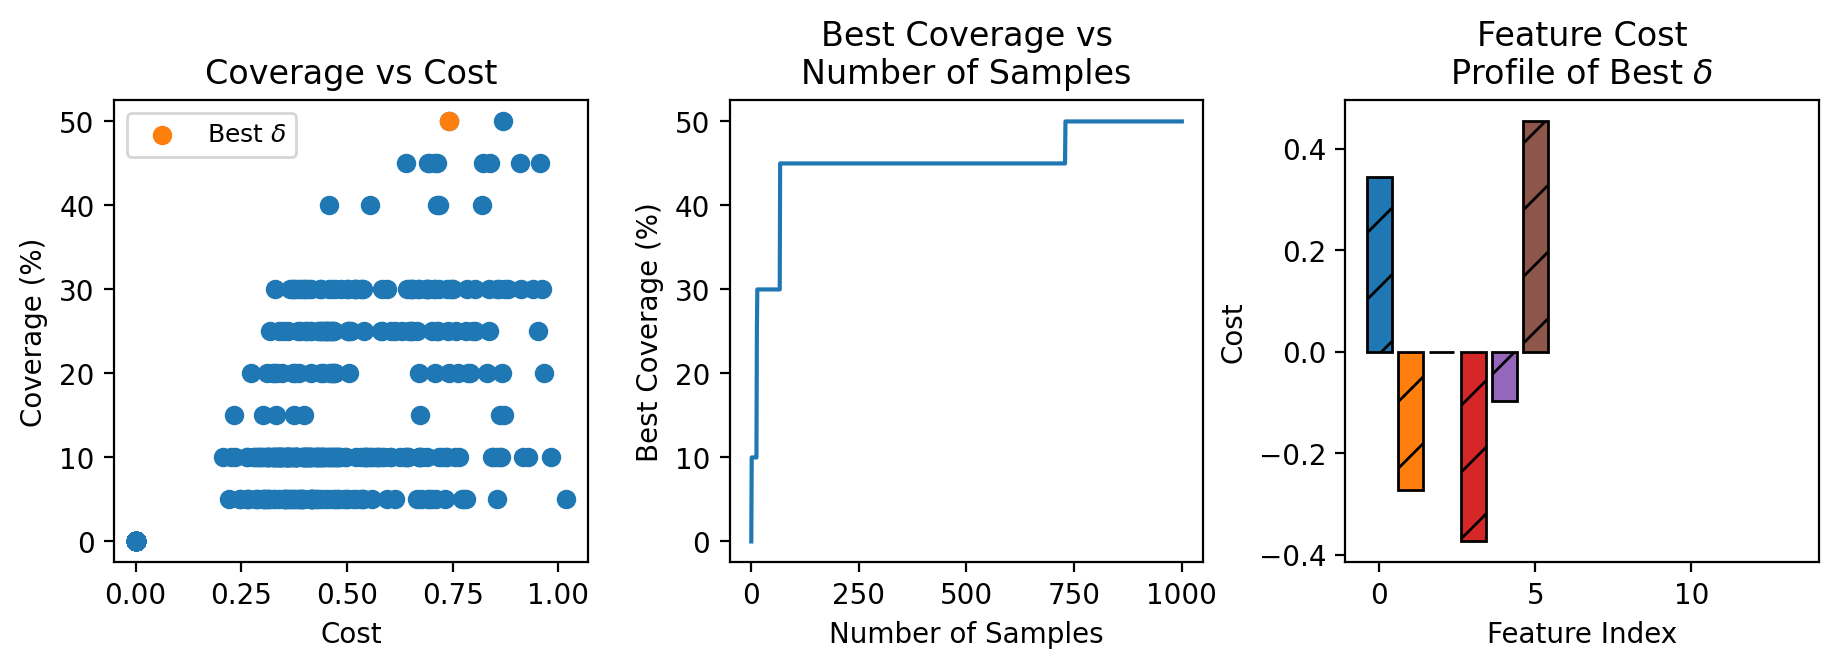

Time taken to find n=3 best deltas: 0.001992464065551758 seconds


100%|██████████| 1000/1000 [00:00<00:00, 4943.28it/s]

Unable to find recourse for 0/20 inputs
Average: 1.5918874615722358


In [6]:
group = 0
FN_group = FN[FN['sex = Female'] == 1].iloc[:, :-1] 

FN_group_index_list = FN_group.index.tolist()
print(f"FN for group {group} = {len(FN_group)}")


scalar_cfe_filename = f"{FGCE_DIR}{sep}cfes{sep}{name}{sep}scalar{sep}globe-ce_cfes_scalar_{group_identifier}_{group}_algorithm_{classifier}.json"

delta_cfe_filename = f"{FGCE_DIR}{sep}cfes{sep}{name}{sep}delta{sep}globe-ce_cfes_delta_{group_identifier}_{group}_algorithm_{classifier}.json"


globe_ce = GLOBE_CE(model=clf, dataset=dataset, X=FN_group, affected_subgroup=None,
                dropped_features=[], ordinal_features=[], delta_init='zeros',
                normalise=None, bin_widths=None, monotonicity=None, p=1)

globe_ce.sample(n_sample=1000, magnitude=2, sparsity_power=1,  
            idxs=None, n_features=6, disable_tqdm=False, 
            plot=True, seed=0, scheme='random', dropped_features=["sex = Female","sex = Male","race = African-American","race = Asian","race = Caucasian","race = Hispanic","race = Native American","race = Other"])

delta = globe_ce.best_delta 

ces = globe_ce.round_categorical(globe_ce.x_aff+delta) if globe_ce.n_categorical else globe_ce.x_aff+delta    


delta_ces = {idx: list(ces[i]) for i, idx in enumerate(FN_group_index_list)}


os.makedirs(os.path.dirname(delta_cfe_filename), exist_ok=True)
with open(delta_cfe_filename, 'w') as file:
    json.dump(delta_ces, file)

globe_ce.select_n_deltas(n_div=1)
n_div = globe_ce.deltas_div.shape[0]

min_costs = np.zeros((1, globe_ce.x_aff.shape[0]))
min_costs_idxs = np.zeros((n_div, globe_ce.x_aff.shape[0]))

cor_s, cos_s, k_s, corerects_dict, costs_dict = globe_ce.scale(globe_ce.deltas_div, disable_tqdm=False, vector=True) 

min_costs, min_costs_idxs = globe_ce.min_scalar_costs(cos_s, return_idxs=True, inf=True) 

scalars_per_point = {}
scalars_deltas_per_point = {}
uncovered_FN = []

scalars_per_point = {FN_id: k_s[int(idx)] if idx > 0 else None for idx, FN_id in zip(min_costs_idxs, FN_group_index_list)}
uncovered_FN_indexes = [i for i, scalar in enumerate(scalars_per_point.values()) if scalar is None]
scalars_deltas_per_point_np = np.array([scalar * delta if scalar is not None else None for scalar in scalars_per_point.values()])

mask = np.ones(globe_ce.x_aff.shape[0], dtype=bool)
mask[uncovered_FN_indexes] = False

x_without_uncovered = globe_ce.x_aff[mask]

ces_scaling = globe_ce.round_categorical(x_without_uncovered + scalars_deltas_per_point_np) if globe_ce.n_categorical else x_without_uncovered + scalars_deltas_per_point_np

scaled_ces = {}
scaled_ces = {idx: list(ces_scaling[i]) for i, idx in enumerate(FN_group_index_list) if idx in scalars_per_point}

os.makedirs(os.path.dirname(scalar_cfe_filename), exist_ok=True)
with open(scalar_cfe_filename, 'w') as file:
    json.dump(scaled_ces, file)


non_infinite_values = [x for x in min_costs if math.isfinite(x)]
average = np.mean(non_infinite_values)
print("Average:", average)


FN for group 1 = 208


100%|██████████| 1000/1000 [00:00<00:00, 5610.78it/s]


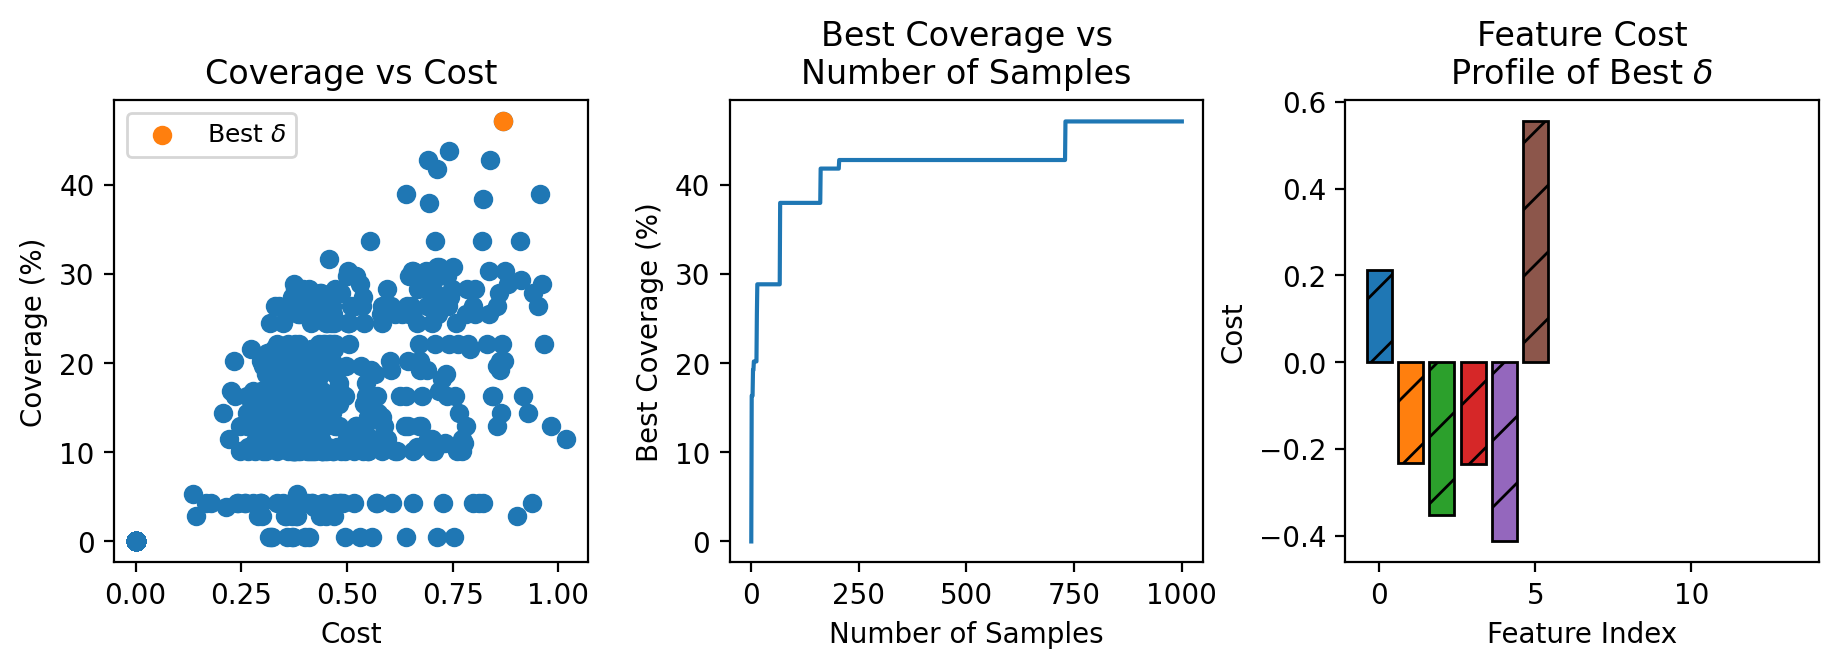

Time taken to find n=3 best deltas: 0.003931760787963867 seconds


100%|██████████| 1000/1000 [00:00<00:00, 4423.58it/s]

Unable to find recourse for 0/208 inputs
Average: 1.7284676621045478


In [7]:
group = 1
FN_group = FN[FN['sex = Male'] == 1].iloc[:, :-1] 
FN_group_index_list = FN_group.index.tolist()
print(f"FN for group {group} = {len(FN_group)}")


scalar_cfe_filename = f"{FGCE_DIR}{sep}cfes{sep}{name}{sep}scalar{sep}globe-ce_cfes_scalar_{group_identifier}_{group}_algorithm_{classifier}.json"

delta_cfe_filename = f"{FGCE_DIR}{sep}cfes{sep}{name}{sep}delta{sep}globe-ce_cfes_delta_{group_identifier}_{group}_algorithm_{classifier}.json"

globe_ce = GLOBE_CE(model=clf, dataset=dataset, X=FN_group, affected_subgroup=None,
                dropped_features=[], ordinal_features=[], delta_init='zeros',
                normalise=None, bin_widths=None, monotonicity=None, p=1)

globe_ce.sample(n_sample=1000, magnitude=2, sparsity_power=1,  
            idxs=None, n_features=6, disable_tqdm=False,  
            plot=True, seed=0, scheme='random', dropped_features=["sex = Female","sex = Male","race = African-American","race = Asian","race = Caucasian","race = Hispanic","race = Native American","race = Other"])

delta = globe_ce.best_delta 

ces = globe_ce.round_categorical(globe_ce.x_aff+delta) if globe_ce.n_categorical else globe_ce.x_aff+delta   


delta_ces = {idx: list(ces[i]) for i, idx in enumerate(FN_group_index_list)}

os.makedirs(os.path.dirname(delta_cfe_filename), exist_ok=True)
with open(delta_cfe_filename, 'w') as file:
    json.dump(delta_ces, file)

globe_ce.select_n_deltas(n_div=1)
n_div = globe_ce.deltas_div.shape[0]


min_costs = np.zeros((1, globe_ce.x_aff.shape[0]))
min_costs_idxs = np.zeros((n_div, globe_ce.x_aff.shape[0]))

cor_s, cos_s, k_s, corerects_dict, costs_dict = globe_ce.scale(globe_ce.deltas_div, disable_tqdm=False, vector=True) 


min_costs, min_costs_idxs = globe_ce.min_scalar_costs(cos_s, return_idxs=True, inf=True) 

scalars_per_point = {}
scalars_deltas_per_point = {}
uncovered_FN = []


scalars_per_point = {FN_id: k_s[int(idx)] if idx > 0 else None for idx, FN_id in zip(min_costs_idxs, FN_group_index_list)}
uncovered_FN_indexes = [i for i, scalar in enumerate(scalars_per_point.values()) if scalar is None]
scalars_deltas_per_point_np = np.array([scalar * delta if scalar is not None else None for scalar in scalars_per_point.values()])

mask = np.ones(globe_ce.x_aff.shape[0], dtype=bool)
mask[uncovered_FN_indexes] = False

x_without_uncovered = globe_ce.x_aff[mask]

ces_scaling = globe_ce.round_categorical(x_without_uncovered + scalars_deltas_per_point_np) if globe_ce.n_categorical else x_without_uncovered + scalars_deltas_per_point_np

scaled_ces = {}

scaled_ces = {idx: list(ces_scaling[i]) for i, idx in enumerate(FN_group_index_list) if idx in scalars_per_point}

os.makedirs(os.path.dirname(scalar_cfe_filename), exist_ok=True)
with open(scalar_cfe_filename, 'w') as file:
    json.dump(scaled_ces, file)


non_infinite_values = [x for x in min_costs if math.isfinite(x)]
average = np.mean(non_infinite_values)
print("Average:", average)


In [8]:
method = "scalar"
globe_cfes = {}
ces_path = f"{FGCE_DIR}{sep}cfes{sep}{name}{sep}{method}"
if os.path.exists(ces_path):
    for filename in os.listdir(ces_path):
        if filename.endswith('.json'):
            if classifier in filename:
                file_path = os.path.join(ces_path, filename)
                try:
                    with open(file_path, 'r') as file:
                        ces_per_group = json.load(file)
                        globe_cfes.update(ces_per_group)		 
                except Exception as e:
                    print(f"Error loading data from {filename}: {e}")

    print("Total entries in globe_cfes:", len(globe_cfes))
else:
    print(f"Directory '{ces_path}' does not exist.")

Total entries in globe_cfes: 228


# Add GLOBE cfes into our graph

In [9]:
def add_globe_cfes_into_data(data_np, data_df, globe_cfes):
    """
    Adds GLOBE-CE cfes into existing data.   
    Parameters:
        data: Existing data.
        globe_cfes: GLOBE cfes.

    Returns:
        DataFrame: Merged DataFrame containing both existing data and GLOBE cfes.
        array: Merged array containing both existing data and GLOBE cfes.
        int: Index where the GLOBE cfes data starts in the merged array.
    """
    data_df = data_df.iloc[:, :-1]  # Drop the last column if needed
    ces_df = pd.DataFrame.from_dict(globe_cfes, orient='index')
    ces_df.columns = data_df.columns
    data_df['sex'] = data_df['sex = Female']
    data_df = data_df.drop(columns=['sex = Female', 'sex = Male'])
    ces_df['sex'] = ces_df['sex = Female']
    ces_df = ces_df.drop(columns=['sex = Female', 'sex = Male'])
    ces_df.reset_index(drop=True, inplace=True)
    
    print(f"Length of data before adding globe's cfes",len(data_df))
    
    ces_df = ces_df.rename(columns=dict(zip(ces_df.columns, list(data_df.columns))))
        
    data_with_globe_cfes_df = pd.concat([data_df, ces_df], axis=0)
    data_with_globe_cfes_df.reset_index(drop=True, inplace=True)

    ces_np = ces_df.to_numpy()
    data_with_globe_cfes_np = np.concatenate((data_np, ces_np))
    ces_start_index = len(data_np)
    print(f"Length of data after adding globe's cfes",len(data_with_globe_cfes_df))
    return data_with_globe_cfes_df, data_with_globe_cfes_np, ces_start_index

In [10]:
epsilon = 0.3
skip_distance_calculation = False
skip_graph_creation = False
baseline = "Globe"
dataset_name = "Compas"


race_columns = [col for col in dataset.data.columns if 'race' in col]
new_race_columns = [f'race_{i}' for i in range(len(race_columns))]
rename_dict = dict(zip(race_columns, new_race_columns))
dataset.data.rename(columns=rename_dict, inplace=True)

data_copy = dataset.data.copy()

dataset.data['sex'] = dataset.data['sex = Female']
dataset.data = dataset.data.drop(columns=['sex = Female', 'sex = Male'])


current_columns = dataset.data.columns.tolist()
new_order = [col for col in current_columns if col not in ['sex', 'two_year_recid']] + ['sex', 'two_year_recid']
dataset.data = dataset.data[new_order]

data_np = dataset.data.to_numpy()

attr_col_mapping = {col: i for i, col in enumerate(dataset.data.columns)}
FEATURE_COLUMNS = dataset.data.columns[:-1]
TARGET_COLUMNS = dataset.data.columns[-1]
X = data_np[:, [attr_col_mapping[col] for col in FEATURE_COLUMNS]]

X_copy = X.copy()
 
data_with_globe_cfes_df, data_with_globe_cfes_np, ces_start_index = add_globe_cfes_into_data(X_copy, data_copy, globe_cfes)

min_max_scaler = preprocessing.MinMaxScaler()
data_with_globe_cfes_scaled = min_max_scaler.fit_transform(data_with_globe_cfes_np)
data_with_globe_cfes_scaled_df = pd.DataFrame(data_with_globe_cfes_scaled, columns=data_with_globe_cfes_df.columns)

min_max_scaler1 = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler1.fit_transform(X)


kernel = Kernel_obj(dataset_name, X, skip_bandwith_calculation=False, bandwith_approch="mean_scotts_rule")
kernel.fitKernel(X_scaled)

fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, epsilon, clf)

feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=dataset_name)

distances = []
densities = []

if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}"):
	os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}")

if skip_distance_calculation and skip_graph_creation and "Distances"+baseline+".pkl" in os.listdir(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}")\
	and f"Graph_"+str(epsilon)+"_"+baseline+".pkl" in os.listdir(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs"):

	graph = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}Graph_{str(epsilon)}_{baseline}.pkl", "rb"))
	kernel = Kernel_obj(dataset_name, X, skip_bandwith_calculation=False, bandwith_approch="mean_scotts_rule")
	kernel.fitKernel(X)
	fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, epsilon, clf)
	fgce.set_graph(graph)
	print("Loading distances from file ...")
	distances = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Distances.pkl", "rb"))

	print("Loading densities from file ...")
	densities = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Densities{sep}Densities_{epsilon}.pkl", "rb"))
else:
	kernel = Kernel_obj(dataset_name, X, skip_bandwith_calculation=False, bandwith_approch="mean_scotts_rule")
	kernel.fitKernel(X)
	fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, epsilon, clf)
	dng_obj = GraphBuilder(feasibility_constraints, FEATURE_COLUMNS, data_with_globe_cfes_scaled, kernel, exclude_columns=True)
	
	distances, graph, densities = dng_obj.compute_pairwise_distances_and_graph_within_subgroups(dataset_name, data_with_globe_cfes_scaled_df, epsilon, feasibility_constraints, None)
    
	if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}"):
			os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}")
	if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Densities{sep}"):
		os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Densities")

	pk.dump(graph, open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}Graph_{str(epsilon)}_{baseline}.pkl", "wb"))
	pk.dump(distances, open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Distances.pkl", "wb"))
	pk.dump(densities, open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Densities{sep}Densities_{epsilon}.pkl", "wb"))

fully_connected_nodes = len(data_with_globe_cfes_df)
connected_nodes = len(graph)
node_connectivity = connected_nodes / fully_connected_nodes * 100
print(f"{connected_nodes} nodes are connected out of {fully_connected_nodes} nodes. Connectivity: {node_connectivity}%")

fully_connected_edges = (fully_connected_nodes * (fully_connected_nodes - 1)) / 2
connected_edges = len(graph.edges())
edge_connectivity = connected_edges / fully_connected_edges * 100
print(f"{connected_edges} edges are connected out of {fully_connected_edges} edges. Connectivity: {edge_connectivity}%")

Length of data before adding globe's cfes 6167
Length of data after adding globe's cfes 6395
Calculating bandwidth for Compas...
Bandwidth: 1.8093916740500833
Fitting kernel...
Calculating bandwidth for Compas...
Bandwidth: 1.8093916740500833
Fitting kernel...


Building graph for subgroup...: 100%|██████████| 58/58 [00:00<00:00, 221.82it/s]


6395 nodes are connected out of 6395 nodes. Connectivity: 100.0%
1352063 edges are connected out of 20444815.0 edges. Connectivity: 6.61323176560903%


In [11]:
path_num = 0
total_distances = 0
ces_id = ces_start_index
nodes = list(graph.nodes())
for FN_id, cfe in globe_cfes.items(): 
    if int(FN_id) in nodes and ces_id in nodes:
        if nx.has_path(graph, int(FN_id), ces_id):          
            path_cost_wij, path = nx.single_source_dijkstra(graph, int(FN_id), target=ces_id, weight='wij') 
            distance = distances[int(FN_id)][ces_id]
            total_distances += distance
            path_num += 1
    ces_id += 1

average_distance_cost = total_distances / path_num if path_num != 0 else 0

percentage_of_paths_found = (path_num / len(FN)) 

print(f"Number of paths found = {percentage_of_paths_found}")
print(f"Average distance cost by Globe = {average_distance_cost}")

Number of paths found = 0.0
Average distance cost by Globe = 0


# FGCE

In [12]:
import os
 
epsilon = 0.3
skip_distance_calculation = False
skip_graph_creation = False
baseline = "fgce"

data = dataset.data.copy()

min_max_scaler = preprocessing.MinMaxScaler()
data_np = min_max_scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_np, columns=data.columns)


attr_col_mapping = {col: i for i, col in enumerate(data.columns)}
FEATURE_COLUMNS = data.columns[:-1]
TARGET_COLUMNS = data.columns[-1]
X = data_np[:, [attr_col_mapping[col] for col in FEATURE_COLUMNS]]


dataset_name = "Compas"

distances = []
densities = []

if skip_distance_calculation and skip_graph_creation and\
				os.path.exists(f"{FGCE_DIR}/tmp/{dataset_name}/Graphs/Graph_{epsilon}.pkl")\
					and os.path.exists(f"{FGCE_DIR}/tmp/{dataset_name}/Distances.pkl") and os.path.exists(f"{FGCE_DIR}/tmp/{dataset_name}/Densities/Densities_{epsilon}.pkl"):
		print("Loading graph from file ...")
		graph = pk.load(open(f"{FGCE_DIR}/tmp/{dataset_name}/Graphs/Graph_{epsilon}.pkl", "rb"))
		kernel = Kernel_obj(dataset_name, X, skip_bandwith_calculation=False, bandwith_approch="mean_scotts_rule")
		kernel.fitKernel(X)
		fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, epsilon, clf)
		fgce.set_graph(graph)

		print("Loading distances from file ...")
		distances = pk.load(open(f"{FGCE_DIR}/tmp/{dataset_name}/Distances.pkl", "rb"))

		print("Loading densities from file ...")
		densities = pk.load(open(f"{FGCE_DIR}/tmp/{dataset_name}/Densities/Densities_{epsilon}.pkl", "rb"))

else:
    kernel = Kernel_obj(dataset_name, X, skip_bandwith_calculation=False, bandwith_approch="mean_scotts_rule")
    kernel.fitKernel(X)
    fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, epsilon, clf)
    feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=dataset_name)

    dng_obj = GraphBuilder(feasibility_constraints, FEATURE_COLUMNS, X, kernel, exclude_columns=True)
    distances, graph, densities = dng_obj.compute_pairwise_distances_and_graph_within_subgroups(dataset_name, data_scaled_df[FEATURE_COLUMNS], epsilon, feasibility_constraints, None)

    if not os.path.exists(f"{FGCE_DIR}/tmp/{dataset_name}/Graphs/"):
        os.makedirs(f"{FGCE_DIR}/tmp/{dataset_name}/Graphs/")
    if not os.path.exists(f"{FGCE_DIR}/tmp/{dataset_name}/Densities/"):
        os.makedirs(f"{FGCE_DIR}/tmp/{dataset_name}/Densities")

    pk.dump(graph, open(f"{FGCE_DIR}/tmp/{dataset_name}/Graphs/Graph_{epsilon}.pkl", "wb"))
    pk.dump(distances, open(f"{FGCE_DIR}/tmp/{dataset_name}/Distances.pkl", "wb"))
    pk.dump(densities, open(f"{FGCE_DIR}/tmp/{dataset_name}/Densities/Densities_{epsilon}.pkl", "wb"))

fully_connected_nodes = len(data_np)
connected_nodes = len(graph)
node_connectivity = connected_nodes / fully_connected_nodes * 100
print(f"{connected_nodes} nodes are connected out of {fully_connected_nodes} nodes. Connectivity: {node_connectivity}%")

fully_connected_edges = (fully_connected_nodes * (fully_connected_nodes - 1)) / 2
connected_edges = len(graph.edges())
edge_connectivity = connected_edges / fully_connected_edges * 100
print(f"{connected_edges} edges are connected out of {fully_connected_edges} edges. Connectivity: {edge_connectivity}%")


Calculating bandwidth for Compas...
Bandwidth: 0.06012535332960527
Fitting kernel...
Calculating bandwidth for Compas...
Bandwidth: 0.06012535332960527
Fitting kernel...


Building graph for subgroup...: 100%|██████████| 58/58 [00:00<00:00, 305.86it/s]


6167 nodes are connected out of 6167 nodes. Connectivity: 100.0%
1024279 edges are connected out of 19012861.0 edges. Connectivity: 5.387295473311459%


In [13]:
x_train['sex'] = x_train['sex = Female']
x_train = x_train.drop(columns=['sex = Female', 'sex = Male'])
x_test['sex'] = x_test['sex = Female']
x_test = x_test.drop(columns=['sex = Female', 'sex = Male'])
FN['sex'] = FN['sex = Female']
FN = FN.drop(columns=['sex = Female', 'sex = Male'])

positives_df["sex"] = positives_df['sex = Female']
positives_df = positives_df.drop(columns=['sex = Female', 'sex = Male'])
positive_points_converted = {}
for x_id, x in positives_df.iterrows():
    positive_points_converted[x_id] = x

X_train_np = x_train.to_numpy()
X_test_np = x_test.to_numpy()
y_train_np = y_train.to_numpy().reshape(-1, 1)
y_test_np = y_test.to_numpy().reshape(-1, 1)
data_test = np.concatenate((X_test_np, y_test_np), axis=1)
index_mapping = {new_index: original_index for new_index, original_index in enumerate(x_test.index)}

subgroups = utils.get_subgraphs_by_group(graph, data_np, data, attr_col_mapping, group_identifier, None, [])


In [14]:
pip install pulp


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\papan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
FN_lst = FN.index.tolist()
gcfes, res = fgce.get_gcfes_approach_integer_prog_global(subgroups, distances, positive_points_converted, FN_lst, 9, 0.9)

Group 0.0
False points with path to at least one positive point = 5
Positive points with path to at least one false negative point = 21
False points with path to at least one positive point = 113
Positive points with path to at least one false negative point = 91
False points with path to at least one positive point = 1
Positive points with path to at least one false negative point = 14
False points with path to at least one positive point = 43
Positive points with path to at least one false negative point = 107
False points with path to at least one positive point = 16
Positive points with path to at least one false negative point = 82
False points with path to at least one positive point = 1
Positive points with path to at least one false negative point = 31
False points with path to at least one positive point = 11
Positive points with path to at least one false negative point = 117
False points with path to at least one positive point = 15
Positive points with path to at least one 